In [2]:
#Murat Şahin Istanbul ilçe bazında su tüketimi analizi ve makine öğrenmesi çalışmasıdır.

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-consumption-statistics-bydistrict-inistanbul/ilce-baznda-su-tuketim-miktar-2000-2015.xlsx
/kaggle/input/water-consumption-statistics-bydistrict-inistanbul/ilce-baznda-su-tuketim-miktar-2015-2022.xlsx
/kaggle/input/water-consumption-statistics-bydistrict-inistanbul/ilce-baznda-su-tuketim-miktar-2023.xlsx
/kaggle/input/water-volume-and-daily-demand-in-istanbuls-dams/istanbul-barajlarnda-ya-ve-gunluk-tuketim-verileri.xlsx


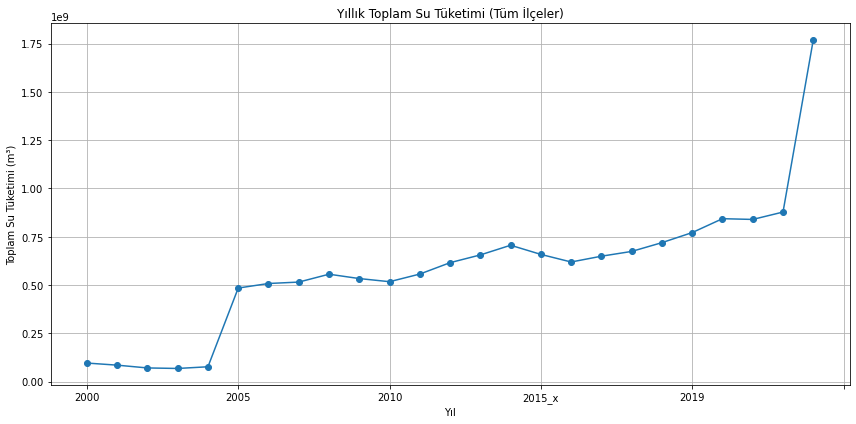

In [5]:
# İlk olarak dosyaları okuyalım ve analiz için birleştirelim
import pandas as pd
import matplotlib.pyplot as plt
# Dosya yollarını tanımlayalım
file_2000_2015 = '/kaggle/input/water-consumption-statistics-bydistrict-inistanbul/ilce-baznda-su-tuketim-miktar-2000-2015.xlsx'
file_2015_2022 = '/kaggle/input/water-consumption-statistics-bydistrict-inistanbul/ilce-baznda-su-tuketim-miktar-2015-2022.xlsx'
file_2023 = '/kaggle/input/water-consumption-statistics-bydistrict-inistanbul/ilce-baznda-su-tuketim-miktar-2023.xlsx'

df_2000_2015 = pd.read_excel(file_2000_2015)
df_2015_2022 = pd.read_excel(file_2015_2022)
df_2023 = pd.read_excel(file_2023)


# 2000-2015 ve 2015-2022 dosyalarındaki sütun isimlendirmesini düzeltelim
df_2000_2015.columns = ['ILCE', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000']
df_2015_2022.columns = ['ILCE', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015']

# 2023 yılı verisinde her ayı yıllık toplam yapalım
df_2023_cleaned = df_2023.drop(columns=['Unnamed: 13'], errors='ignore')  # Gereksiz sütunları kaldırma
df_2023_cleaned['2023'] = df_2023_cleaned.iloc[:, 1:].sum(axis=1)  # Aylık verileri toplayıp yıllık yapıyoruz
df_2023_cleaned = df_2023_cleaned[['İLÇELER ', '2023']]  # Sadece ilçe ve 2023 verisini tutuyoruz
df_2023_cleaned.columns = ['ILCE', '2023']  # Sütunları standart hale getiriyoruz

# Tüm dosyaları birleştirelim
df_combined = pd.merge(df_2000_2015, df_2015_2022, on='ILCE', how='outer')
df_combined = pd.merge(df_combined, df_2023_cleaned, on='ILCE', how='outer')

# Veriyi uzun formata dönüştürelim
df_combined_melted = df_combined.melt(id_vars='ILCE', var_name='Year', value_name='Water_Consumption')

# Yıllara göre gruplayarak toplam su tüketimini bulalım
df_combined_melted['Water_Consumption'] = pd.to_numeric(df_combined_melted['Water_Consumption'], errors='coerce')
yearly_consumption = df_combined_melted.groupby('Year')['Water_Consumption'].sum()

# Grafik oluşturalım
plt.figure(figsize=(12, 6))
yearly_consumption.plot(kind='line', marker='o')
plt.title('Yıllık Toplam Su Tüketimi (Tüm İlçeler)')
plt.xlabel('Yıl')
plt.ylabel('Toplam Su Tüketimi (m³)')
plt.grid(True)
plt.tight_layout()
plt.show()


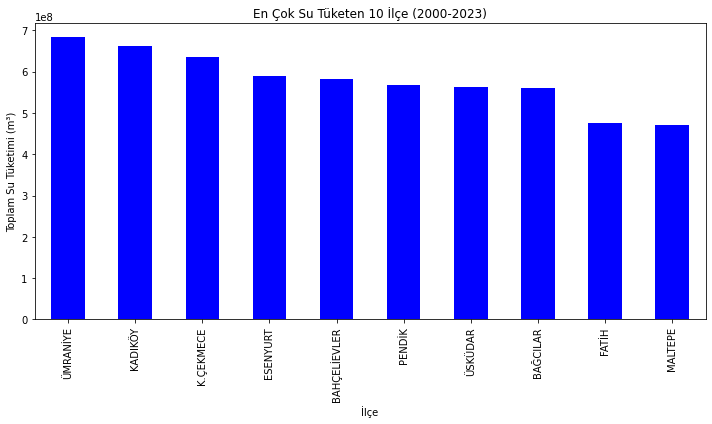

In [9]:
# İlçelere göre toplam su tüketimini bulalım
district_total_consumption = df_combined_melted.groupby('ILCE')['Water_Consumption'].sum()

# 'Genel Toplam' ifadesi veya benzer bir şey var mı kontrol edelim ve filtreleyelim
district_total_consumption = district_total_consumption[~district_total_consumption.index.str.contains('Genel Toplam', case=False, na=False)]

# Su tüketimine göre en çok tüketen 10 ilçe
top_10_districts = district_total_consumption.sort_values(ascending=False).head(10)

# Grafiği çizelim
plt.figure(figsize=(10, 6))
top_10_districts.plot(kind='bar', color='blue')
plt.title('En Çok Su Tüketen 10 İlçe (2000-2023)')
plt.xlabel('İlçe')
plt.ylabel('Toplam Su Tüketimi (m³)')
plt.tight_layout()
plt.show()


C:\Users\murat\AppData\Local\Temp\ipykernel_8248\2843436037.py:11: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.

  plt.plot(ilce_data['Year'], ilce_data['Water_Consumption'], label=ilce)


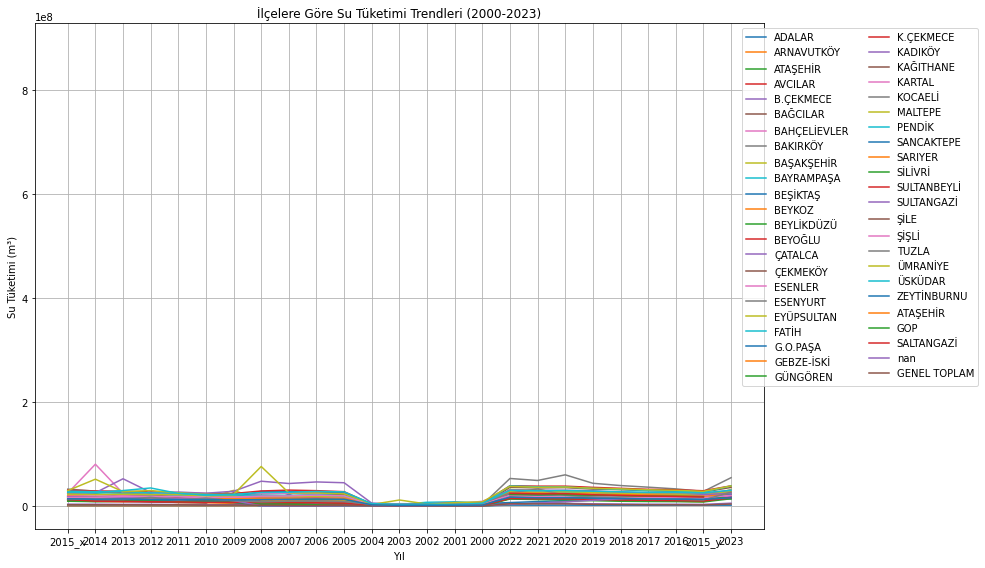

In [14]:
# Veriyi yeniden düzenleyelim: İlçe ve yıl bazında gruplayalım ve yıllık toplam su tüketimini hesaplayalım
df_combined_melted['Water_Consumption'] = pd.to_numeric(df_combined_melted['Water_Consumption'], errors='coerce')
df_combined_melted.dropna(subset=['Water_Consumption'], inplace=True)

# İlçelere göre yıllık su tüketim trendini hazırlayalım
plt.figure(figsize=(14, 8))

# Her ilçe için trendi çizelim
for ilce in df_combined_melted['ILCE'].unique():
    ilce_data = df_combined_melted[df_combined_melted['ILCE'] == ilce]
    plt.plot(ilce_data['Year'], ilce_data['Water_Consumption'], label=ilce)

plt.title('İlçelere Göre Su Tüketimi Trendleri (2000-2023)')
plt.xlabel('Yıl')
plt.ylabel('Su Tüketimi (m³)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=2)  # Legend'ı dışarı taşıyoruz
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\murat\AppData\Local\Temp\ipykernel_8248\2658984798.py:13: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.

  plt.plot(ilce_data['Year'], ilce_data['Water_Consumption'], label=ilce)


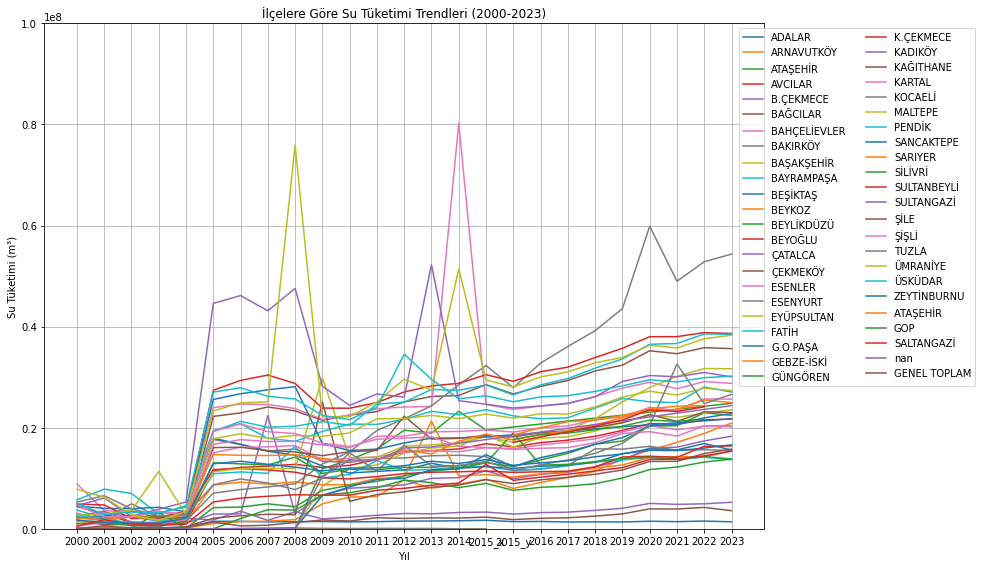

In [21]:
# Veriyi yeniden düzenleyelim: İlçe ve yıl bazında gruplayalım ve yıllık toplam su tüketimini hesaplayalım
df_combined_melted['Water_Consumption'] = pd.to_numeric(df_combined_melted['Water_Consumption'], errors='coerce')
df_combined_melted.dropna(subset=['Water_Consumption'], inplace=True)

# İlçelere göre yıllık su tüketim trendini hazırlayalım
plt.figure(figsize=(14, 8))

# Her ilçe için trendi çizelim
for ilce in df_combined_melted['ILCE'].unique():
    ilce_data = df_combined_melted[df_combined_melted['ILCE'] == ilce]
    # Yılı sayısal değerlere dönüştür ve sıralı şekilde grafikte göster
    ilce_data = ilce_data.sort_values(by='Year')
    plt.plot(ilce_data['Year'], ilce_data['Water_Consumption'], label=ilce)

# Y eksenini 0 ile 100000000 arasında sınırlandıralım
plt.ylim(0, 100000000)

plt.title('İlçelere Göre Su Tüketimi Trendleri (2000-2023)')
plt.xlabel('Yıl')
plt.ylabel('Su Tüketimi (m³)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=2)  # Legend'ı dışarı taşıyoruz
plt.grid(True)
plt.tight_layout()
plt.show()
